# Read prepared data:

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path1 = '/content/drive/MyDrive/VU/ANN/prepared_train_data.csv'
path2 = '/content/drive/MyDrive/VU/ANN/prepared_test_data.csv'
train_df = pd.read_csv(path1)
test_df = pd.read_csv(path2)
# Pop out the id's:
test_id = test_df['id']
X_test = test_df.drop('id', axis=1)

In [ ]:
# Pop out the target data:
Y_train = train_df['sales']
X_train = train_df.drop('sales', axis=1)

# Prepare & train:

In [ ]:
# Convert dataframes to tensors
X_tensor = torch.tensor(X_train.values[:,:,None], dtype=torch.float32)
print(X_tensor.shape)
#X_tensor

torch.Size([3052566, 87, 1])


In [ ]:
# Create a Dataset from tensor
dataset = TensorDataset(X_tensor, torch.tensor(Y_train.values, dtype=torch.float32))

# Define the DataLoader
BATCH_SIZE = 1713  # As seen in previous notebook, each store-item has 1713 entries
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)   # if batch size changes, disable shuffle!

Initialize model:

In [ ]:
class FeedForwardN(nn.Module):
    def __init__(self, input_channels, sequence_length, num_classes=1, dropout_rate=0.2):
        super(FeedForwardN, self).__init__()

        # Activation Function
        self.relu = nn.ReLU()

        # Dropout Layer
        self.dropout = nn.Dropout(p=dropout_rate)

        # Fully Connected Layers
        self.fc1 = nn.Linear(sequence_length * input_channels, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.dropout(self.relu(self.fc4(x)))
        x = self.dropout(self.relu(self.fc5(x)))
        x = self.fc6(x)
        return x.squeeze(-1)



#Use GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Model Initialization
input_channels = X_tensor.shape[1]
sequence_length = X_tensor.shape[2]
model = FeedForwardN(input_channels, sequence_length).to(device)  # Move model to GPU if available

#Loss Function
criterion = nn.MSELoss()
previous_epoch_loss = None  # Initialize a variable to store the previous epoch's loss
#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

Training loop:

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    start_time = datetime.datetime.now()  # Start time for the epoch

    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()  # Reset gradients
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    end_time = datetime.datetime.now()  # End time for the epoch
    time_taken = end_time - start_time

    epoch_loss = running_loss / len(data_loader)
    if previous_epoch_loss is not None:
        improvement = previous_epoch_loss - epoch_loss  # Calculate improvement
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f} Improvement: {improvement:.4f} Time: {time_taken}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f} Time: {time_taken}")

# 6. Model Saving
torch.save(model.state_dict(), 'model_weights.pth')

Epoch [1/10] Loss: 521399.5139 Time: 0:00:40.004211
Epoch [2/10] Loss: 303717.6541 Time: 0:00:39.918189
Epoch [3/10] Loss: 294193.9654 Time: 0:00:39.742611
Epoch [4/10] Loss: 288220.9129 Time: 0:00:39.696294
Epoch [5/10] Loss: 282953.9823 Time: 0:00:39.958486
Epoch [6/10] Loss: 278462.4823 Time: 0:00:40.135951
Epoch [7/10] Loss: 275729.6246 Time: 0:00:40.148406
Epoch [8/10] Loss: 273055.5821 Time: 0:00:40.081704
Epoch [9/10] Loss: 270233.6946 Time: 0:00:39.858902
Epoch [10/10] Loss: 266638.2467 Time: 0:00:39.957625


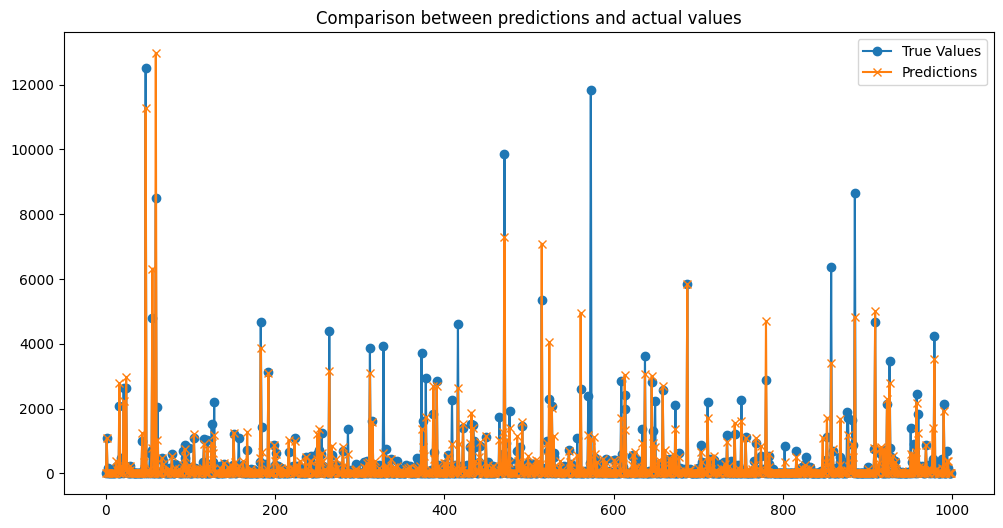

In [ ]:

# Take a batch from the DataLoader
data, target = next(iter(data_loader))

# Move data to the same device as the model (if using GPU)
data = data.to(device)

# Make predictions
with torch.no_grad():  # We don't need gradients for this step
    predictions = model(data)

# Move predictions to CPU for plotting
predictions = predictions.cpu()

# Plotting a sample of the results
plt.figure(figsize=(12, 6))
plt.plot(target[:1000], label='True Values', marker='o')  # Taking first 100 for visualization purposes
plt.plot(predictions[:1000], label='Predictions', marker='x')
plt.legend()
plt.title('Comparison between predictions and actual values')
plt.show()

# Predict on test set:

In [ ]:
# Convert dataframes to tensors

X_tensor = torch.tensor(X_test.values[:,:,None], dtype=torch.float32)
print(X_tensor.shape)

torch.Size([28512, 87, 1])


In [ ]:
# Define the DataLoader
BATCH_SIZE = 16  # each store-item has 16 entries to predict
data_loader = DataLoader(X_tensor, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
# 1. Model Initialization
input_channels = X_tensor.shape[1]
sequence_length = X_tensor.shape[2]
model = FeedForwardN(input_channels, sequence_length).to(device)

# 2. Load the Model Weights
model.load_state_dict(torch.load('model_weights.pth'))

# 3. Set the model to evaluation mode
model.eval()

# 4. Predict using the model
predictions = []
with torch.no_grad():
    for data in data_loader:
        data = data.to(device)
        outputs = model(data)
        predictions.extend(outputs.cpu().numpy())

# Convert predictions to a numpy array
predictions = np.array(predictions)

convert to sumbission file:

In [ ]:
# Convert predictions to a pandas DataFrame
predictions_df = pd.DataFrame(predictions, columns=["sales"])

# Concatenate test_id with predictions
submission_df = pd.concat([test_id.reset_index(drop=True), predictions_df], axis=1)
submission_df = submission_df.sort_values(by=['id'], ascending=[True])


model gives negative & round predictions that can be fixed with ceiling & rounding them to 0:

In [ ]:
negative_predictions_count = (submission_df['sales'] <= 0).sum()
print(negative_predictions_count)

0


In [ ]:
submission_df.loc[submission_df['sales'] <= 0, 'sales'] = 0
# submission_df['sales'] = submission_df['sales'].round()

In [ ]:

# Save the dataframe to a CSV file
file_path = '/content/drive/MyDrive/VU/ANN/submission.csv'
submission_df.to_csv(file_path, index=False)

Add a plot of predicted product sales (grouped by each touple(store,product))
id vs sale: